# Advanced Multivariate Statistics
# Lecture 4 - Gaussian Mixtures


In [1]:
!python --version

Python 3.8.15


In [2]:
from sklearn import set_config
from sklearn import __version__

set_config(display='diagram')

print(f"sklearn version: {__version__}")

sklearn version: 1.0.2


## Small addendum: Scoring Metrics

* Can be divided in two categories: those that require the 'true labels' or the 'ground truth', and those which do not.


### Requiring ground truth:

* (Adjusted) Rand Score
* (Adjusted/Normalised) Mutual Information Criterion
* Homogeneity, Completeness and V-Score (harmonic mean of completeness and homogeneity)
* Fowlkes-Mallow Score

Note: use *adjusted* clustering metrics with small cluster and sample sizes to avoid [distortive effects](https://scikit-learn.org/stable/auto_examples/cluster/plot_adjusted_for_chance_measures.html#sphx-glr-auto-examples-cluster-plot-adjusted-for-chance-measures-py).

### Not requiring ground truth

* Silhouette Score
* Calinski-Harabasz Score
* Davies-Bouldin Score

Note: these metrics basically compute the "degree of separation" between clusters and "how well-defined" they are, so they inherently work best with convex clusters. In other words, they can be much harder to interpret with non-convex clusters.

### "Hyperparameter Tuning" with clustering algorithms

When approaching clustering as an unsupervised method, cross-validation cannot be used. The reasoning is simple: clustering metrics do not have a global or local minimum. Inertia keeps on reducing, so the recommended number of clusters should technically be the sample size. The same, more or less, applies to the other metrics. In the end, we should rely on domain knowledge to choose the desired number of clusters.

## Load Data

To respect the balance between classes, we use a more sophisticated train/test splitting strategy:

In [3]:
import pandas as pd

url = "https://raw.githubusercontent.com/allisonhorst/palmerpenguins/master/inst/extdata/penguins.csv"

penguins = pd.read_csv(url).dropna()

penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007


In [4]:
data, target = penguins.drop(columns=["species", "year"]), penguins.filter(["species"])

 ## Stratified Train-Test Split

In [5]:
from sklearn.model_selection import StratifiedKFold

strat_kfold = StratifiedKFold(n_splits=4)

The `strat_kfold` object has `.split()` method that can be used to iterate over the dataset and produce the specified number of **folds**. These are meant to be used in **cross-validation** settings.

In [6]:
strat_kfold.split(data, target)

<generator object _BaseKFold.split at 0x7fa0bd795cf0>

The object above is a [`generator`](https://www.youtube.com/watch?v=tmeKsb2Fras). Generator objects do not `return` an object, but rather `yield` a result until it is *exhausted*.

This generator will yield up to `n_splits` different results when it is iterated over.

What are the results of this object? Different combinations of indexes that are used to split the data in a training and validation set.

Since we only need one split (in train- and test-set), we can use a dirtier and less pythonic trick:

In [7]:
train_idx, test_idx = next(strat_kfold.split(data, target))

print(train_idx.shape, test_idx.shape)

(249,) (84,)


Note that the number of rows adds up to 150 - the dimension of our dataset. If we called `next()` on the splitter, we'd get the same total number, but different index.

In [8]:
# train set
data_train, target_train = data.iloc[train_idx], target.iloc[train_idx]

# target set
data_test, target_test = data.iloc[test_idx], target.iloc[test_idx]

## Data Preprocessing Pipeline


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 333 entries, 0 to 343
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   island             333 non-null    object 
 1   bill_length_mm     333 non-null    float64
 2   bill_depth_mm      333 non-null    float64
 3   flipper_length_mm  333 non-null    float64
 4   body_mass_g        333 non-null    float64
 5   sex                333 non-null    object 
dtypes: float64(4), object(2)
memory usage: 18.2+ KB


In [10]:
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

ohe = OneHotEncoder(drop="first", sparse=False, dtype="int")

preprocessor = ColumnTransformer(
    [
        ("encoder", ohe, selector(dtype_include="object")),
        ("scaler", StandardScaler(), selector(dtype_exclude="object"))
    ],
    remainder="passthrough"
)

## Gaussian Mixtures: Example

GMMs are unsupervised models: here we are using the `iris` dataset (which is notoriously used in a supervised setting) just to display the different covariance types.

In [11]:
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline

estimator = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("mixture", GaussianMixture(n_components=3, covariance_type="full"))
    ]
)

_ = estimator.fit(data_train)

To retrieve the in-sample predictions, we should call the `predict` method on the training data:

In [12]:
labels_train = estimator.predict(data_train)
labels_test = estimator.predict(data_test)

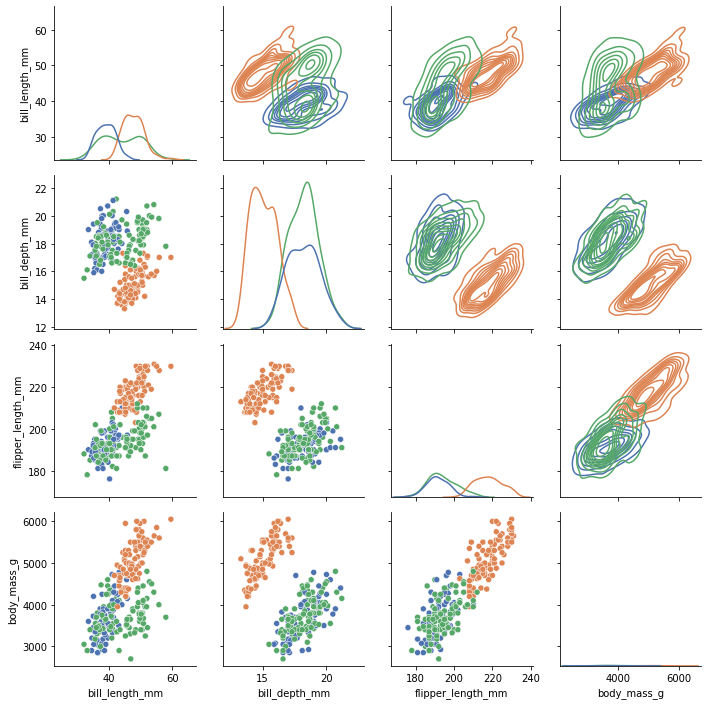

In [13]:
import seaborn as sns

palette = sns.color_palette("deep")

g = (
    sns.PairGrid(
        data=data_train.assign(labels=labels_train),
        hue="labels",
        palette=palette[:3]
        )
    .map_diag(sns.kdeplot)
    .map_lower(sns.scatterplot)
    .map_upper(sns.kdeplot)
)

## Gaussian Mixtures: Covariance Types


In [14]:
estimators = {
    cov_type: GaussianMixture(
        n_components=3, covariance_type=cov_type, max_iter=20, random_state=0
    )
    for cov_type in ["spherical", "diag", "tied", "full"]
}

In [15]:
from __future__ import annotations

from typing import Literal
from pathlib import Path

CovarianceType = Literal["spherical", "diag", "tied", "full"]

figs_path = Path("/content/drive/MyDrive/Colab Notebooks/advanced-mutlivariate-statistics") / "figs"

if not figs_path.is_dir():
        figs_path.mkdir()

def plot_gmm(key: CovarianceType, **kwargs):

    preprocessor = kwargs.pop("preprocessor" or preprocessor)
    
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("model", estimators[key])
    ])

    _ = pipeline.fit(data_train)

    labels = pipeline.predict(data_train)

    return (
        sns.PairGrid(
            data=data_train.assign(labels=labels),
            hue="labels",
            )
        .map_diag(sns.kdeplot)
        .map_lower(sns.scatterplot)
        .map_upper(sns.kdeplot)
        .savefig(figs_path / f"{key}.png")
    )

In [16]:
!pip install rich

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
# from rich.progress import track

# _ = [plot_gmm(key) for key in track(estimators.keys())]

## Gaussian Mixtures: Number of Components

In [18]:
estimators = {
    f"covtype_{cov_type}-ncomp_{component}" : GaussianMixture(
        n_components=component,
        covariance_type=cov_type,
        max_iter=20,
        random_state=0
    )
    for cov_type in ["spherical", "diag", "tied", "full"]
    for component in range(2,7)
}

In [19]:
# from rich.progress import track

# _ = [plot_gmm(key) for key in track(estimators.keys())]

## Gaussian Mixture: Evaluation with `sklearn.metrics`

### Tweaking last weeks's function

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score


def compute_gmm_metrics(
    data: np.ndarray,
    *,
    n_components: int,
    covariance: CovarianceType,
    random_state: int
    ) -> tuple(float, float, float):
    
    model = GaussianMixture(
        n_components=n_components,
        covariance_type=covariance,
        random_state=random_state
        )
    
    _ = model.fit(data)

    preds = model.predict(data)

    davies_bouldin = davies_bouldin_score(data, preds)
    silhouette_coefficient = silhouette_score(data, preds, metric="euclidean")
    calinski_harabasz = calinski_harabasz_score(data, preds)

    return davies_bouldin, silhouette_coefficient, calinski_harabasz


def compute_metrics(
    data: pd.DataFrame,
    *,
    max_clusters: int,
    covariance: CovarianceType,
    random_state: int,
    **kwargs,
    ) -> pd.DataFrame:

    _preprocessor = kwargs.pop("preprocessor", preprocessor)

    interim_data: np.ndarray = _preprocessor.fit_transform(data)

    clusters_range = np.arange(2, max_clusters + 1)

    metrics_list = [
        compute_gmm_metrics(
            interim_data,
            covariance=covariance,
            n_components=k,
            random_state=random_state
            )
        for k in clusters_range
        ]

    metrics = pd.DataFrame(
        metrics_list,
        index=clusters_range,
        columns=["davies_bouldin", "silhouette_coefficient", "calinski_harabasz"]
    )

    metrics.index.name = "number_of_clusters"

    return metrics


def plot_metrics(metrics: pd.DataFrame, covariance) -> None:
    
    def plot_metric(metrics, col, ax):
        
        if col == "davies_bouldin":
            plot_title = f"{col.replace('_', ' ').title()} (lower is better)"
        else:
            plot_title = f"{col.replace('_', ' ').title()} (higher is better)"
        
        ax.plot(metrics[col])
        ax.scatter(metrics.index, metrics[col])
        ax.set(
            title=f"{plot_title}",
            xticks=metrics.index
            )

    fig, ax = plt.subplots(1, 3, figsize=(16, 8))
    
    for ax, metric in zip(ax.reshape(-1), metrics.columns):
        plt.suptitle(f"GMM (covariance type: {covariance})")
        plot_metric(metrics, metric, ax)
        

def metrics_pipeline(
    data: pd.DataFrame,
    max_clusters: int,
    covariance: CovarianceType = "full",
    random_state: int = 42,
    **kwargs,
    ) -> None:

    metrics = compute_metrics(
        data=data,
        covariance=covariance,
        max_clusters=max_clusters,
        random_state=random_state,
        **kwargs
        )
    
    plot_metrics(metrics, covariance=covariance)

### Plotting metrics

[None, None, None, None]

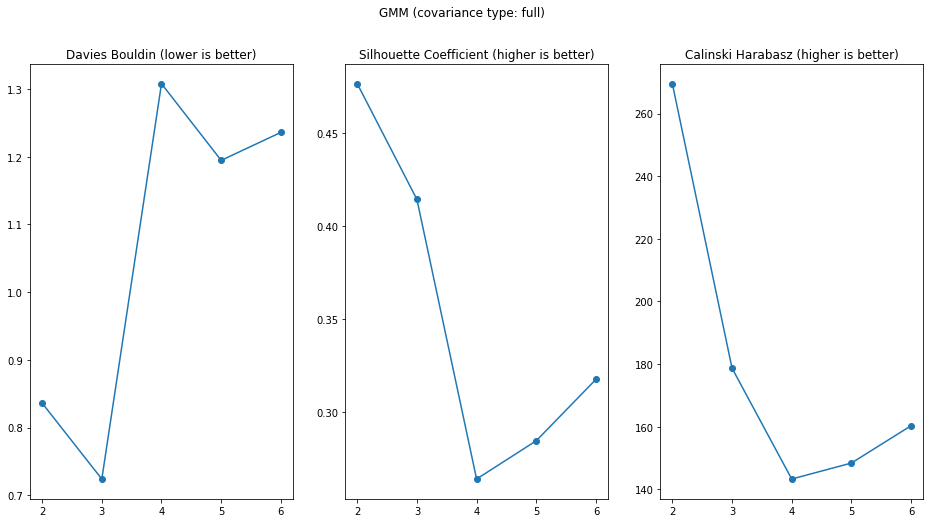

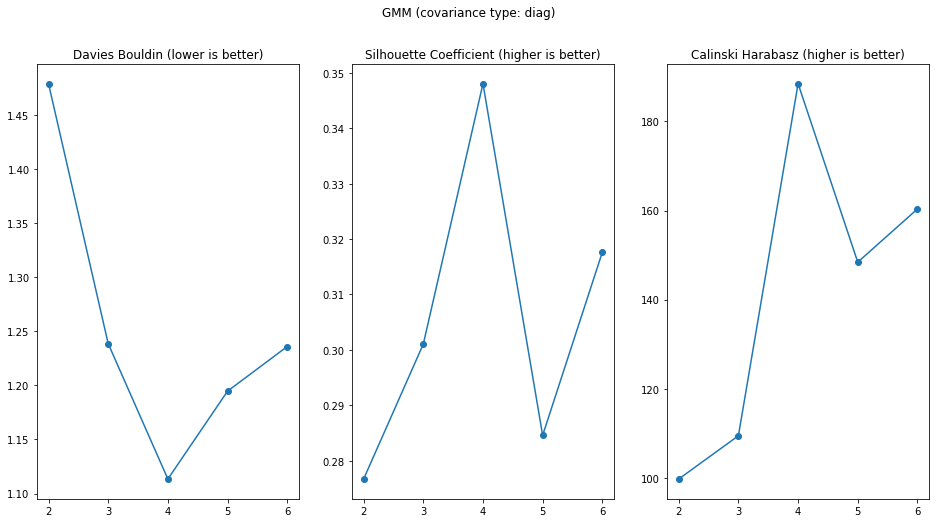

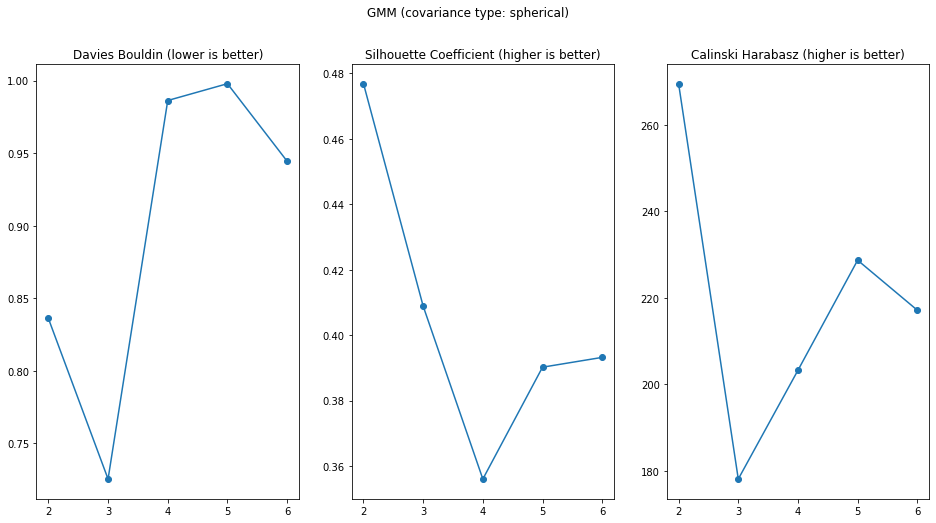

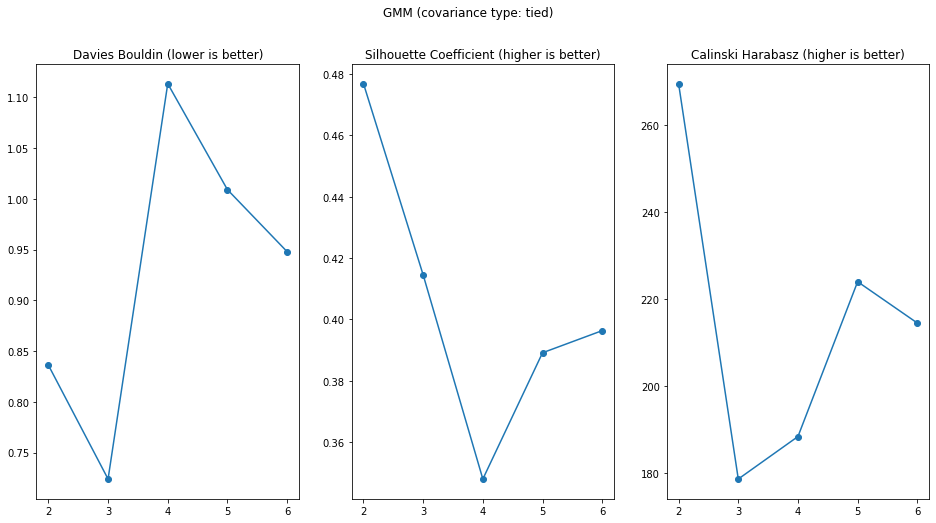

In [21]:
covariances = ["full", "diag", "spherical", "tied"]

[metrics_pipeline(data_train, max_clusters=6, covariance=cov) for cov in covariances]

## Gaussian Mixture: Evaluation using the BIC

### Wrapping inside a Class

In [22]:
from typing import Any

import itertools

import pandas as pd

from sklearn.exceptions import NotFittedError

ExperimentState = ["clear", "fit"]


class GMMExperiment:
    """Encapsulates the steps to perform model selection with a
    Gaussian Mixture.
    """

    def __init__(
            self,
            data: pd.DataFrame | np.ndarray,
            *,
            preprocessor: Any,
            max_components: int,
            **kwargs,
        ) -> None:
        """Initialises the experiment."""

        self.data: pd.DataFrame | np.ndarray = data
        self.preprocessor = preprocessor

        self._components: np.ndarray = np.arange(2, max_components + 1)
        
        # kwargs
        self._random_state: int = kwargs.pop("random_state", None)
        
        # state
        self._covariances: CovarianceType = ["spherical", "tied", "diag", "full"]
        
        self._state: ExperimentState = "clear"
        
        # other methods
        self._params: pd.DataFrame | None = None
        self._best_params: dict[str, int | str] | None = None
        self._colormap = ["navy", "turquoise", "cornflowerblue", "darkorange"]
        self._coloriter = itertools.cycle(self._colormap)
        self._figsize = kwargs.pop("figsize", (12, 12))


    def _bic_get(self, return_best_params: bool = True, **kwargs):
        """Compute the BIC of an individual combination of hyperparameters."""

        n_components = kwargs.pop("n_components", None)
        covariance_type = kwargs.pop("covariance_type", None)

        prep = self.preprocessor
        random_state = self._random_state

        interim_data = prep.fit_transform(data)
        
        model = GaussianMixture(
                n_components=n_components,
                covariance_type=covariance_type,
                random_state=random_state
                )

        _ = model.fit(interim_data)
        
        bic = model.bic(interim_data)

        if return_best_params:
            return n_components, covariance_type, bic
        return bic


    def bics_get(self) -> pd.DataFrame:
        """Return an ordered DataFrame of BIC scores computed using the
        Experiment's n_components range."""

        results = [
            self._bic_get(
                data=self.data,
                return_best_params=True,
                n_components=comp,
                covariance_type=cov,
                )
            for comp in self._components
            for cov in self._covariances
        ]

        self._state = "fit"

        self._params = pd.DataFrame(
            data=results,
            columns=("n_components", "covariance_type", "bic")
        ).sort_values("bic", ascending=True)

        return self._params


    def bics_plot_(self) -> plt.Figure:
        """Just see here: https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html#sphx-glr-auto-examples-mixture-plot-gmm-selection-py

        Can/should/must be optimised.
        """
        if self._state == "clear":
            raise NotFittedError("call 'get_bics' before this")

        bars = []
        bic = self._params.bic.values

        plt.figure(figsize=self._figsize)
        spl = plt.subplot(2, 1, 1)
        
        for i, (cv_type, color) in enumerate(zip(self._covariances, self._coloriter)):
            xpos = self._components + 0.2 * (i - 2)
            bars.append(
                plt.bar(
                    xpos,
                    bic[i * len(self._components) : (i + 1) * len(self._components)],
                    width=0.2,
                    color=color,
                )
            )

        plt.xticks(self._components)
        plt.ylim([bic.min() * 1.01 - 0.01 * bic.max(), bic.max()])
        plt.title("BIC score per model")
        
        xpos = (
            np.mod(bic.argmin(), len(self._components))
            + 0.65
            + 0.2 * np.floor(bic.argmin() / len(self._components))
        )
        
        plt.text(xpos, bic.min() * 0.97 + 0.03 * bic.max(), "*", fontsize=14)
        spl.set_xlabel("Number of components")
        spl.legend([b[0] for b in bars], self._covariances)


    def best_params_get_(self) -> dict[str, str | int]:
        """Get the best parameters to fit a new model."""
        if self._state == "clear":
            raise NotFittedError("call 'get_bics' before this")
        
        self._best_params = self._params.iloc[0, 0:2].to_dict()

        return self._best_params
        

    def best_model_get_(self) -> GaussianMixture:
        """Fit the best GMM chosen using the BIC criterion."""
        if self._state == "clear":
            raise NotFittedError("call 'get_bics' before this")
        
        if self._best_params is None:
            self.best_params_get_()

        best_model = GaussianMixture(
            n_components=self._best_params.get("n_components"),
            covariance_type=self._best_params.get("covariance_type"),
        )

        return Pipeline([
            ("preprocessor", self.preprocessor),
            ("gmm", best_model)
        ])

### Instance the Class

In [23]:
experiment = GMMExperiment(
    data,
    preprocessor=preprocessor,
    max_components=6,
    )

_ = experiment.bics_get()

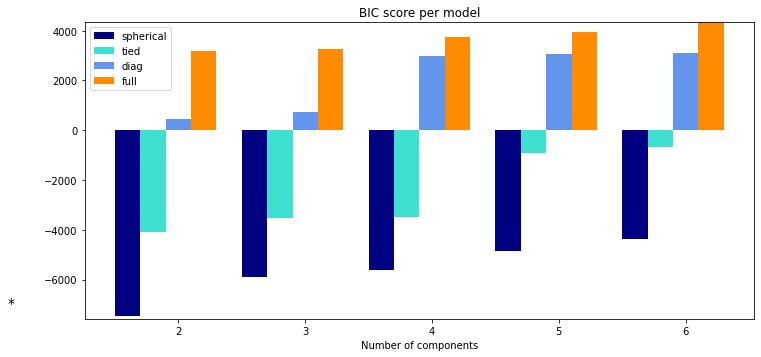

In [24]:
experiment.bics_plot_()